Avi Miletzky

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

# Section 1: Data Science

Load the flights training data into 'data'.

In [2]:
import io
from google.colab import files
uploaded = files.upload()

Saving flight_delays_train.csv to flight_delays_train (1).csv


In [3]:
data = pd.read_csv(io.BytesIO(uploaded['flight_delays_train.csv']))
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


How many flights got delayed at Charlotte?

In [4]:
CLT_flights = data[data['Origin'] == "CLT"]
CLT_flights = CLT_flights[CLT_flights['dep_delayed_15min'] == 'Y']
print(f'{len(CLT_flights)} flights got delayed at Charlotte.')

288 flights got delayed at Charlotte.


Show the number of departures per hour-of-day.

In [5]:
def calculate_DepHour(x):
  hour = x['DepTime'] // 100
  return hour if hour < 24 else (hour - 24)

data['DepHour'] = data.apply(calculate_DepHour, axis=1)
# gb_hour = pd.DataFrame({'Count': data['DepHour'].value_counts().sort_index().rename_axis('DepHour')})
gb_hour = pd.DataFrame({'DepCount': data.groupby('DepHour')['DepHour'].size()})
gb_hour

,DepCount
DepHour,
0,331
1,82
2,27
3,8
4,38
5,1636
6,6315
7,6329
8,6620


Plot number of departures (Y axis) per hour-of-day (X axis).

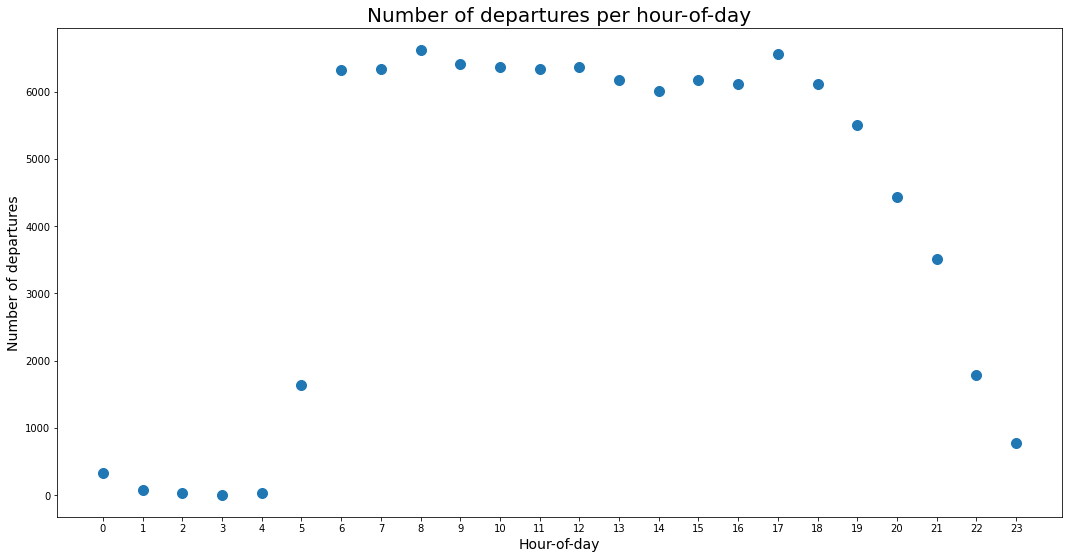

In [6]:
gb_hour.plot(legend=False, figsize=(18,9), linestyle='None', marker='o', markersize = 10.0)

plt.title('Number of departures per hour-of-day', fontsize=20)
plt.xlabel('Hour-of-day', fontsize=14)
plt.ylabel('Number of departures', fontsize=14)
plt.xticks(range(24))

plt.show()

Plot the average number of delays per hour-of-day.

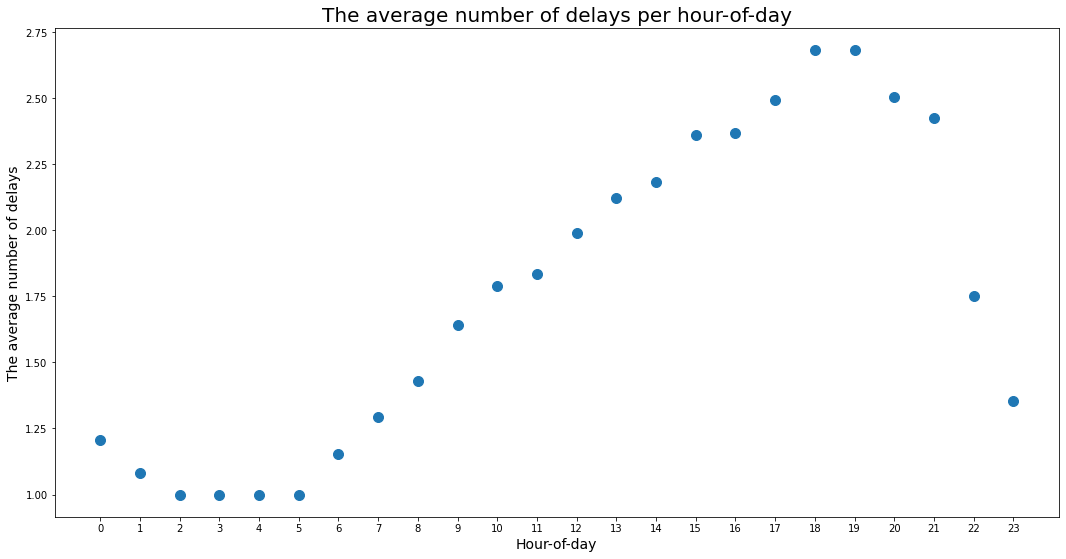

In [7]:
gb_hour['DelaysPerHour'] = data[data['dep_delayed_15min'] == 'Y'].groupby('DepHour')['DepHour'].size()
unique_days = data[data['dep_delayed_15min'] == 'Y'].groupby(['DepHour','Month','DayofMonth','DayOfWeek']).size().reset_index().rename(columns={0:'Count'})
gb_hour['UniqueDaysCount'] = unique_days.groupby('DepHour').size()
gb_hour['DelaysAvg'] = gb_hour['DelaysPerHour'] / gb_hour['UniqueDaysCount']

myplot = gb_hour['DelaysAvg'].plot(legend=False, figsize=(18,9), linestyle='None', marker='o', markersize = 10.0)

plt.title('The average number of delays per hour-of-day', fontsize=20)
plt.xlabel('Hour-of-day', fontsize=14)
plt.ylabel('The average number of delays', fontsize=14)
plt.xticks(range(24))

plt.show()

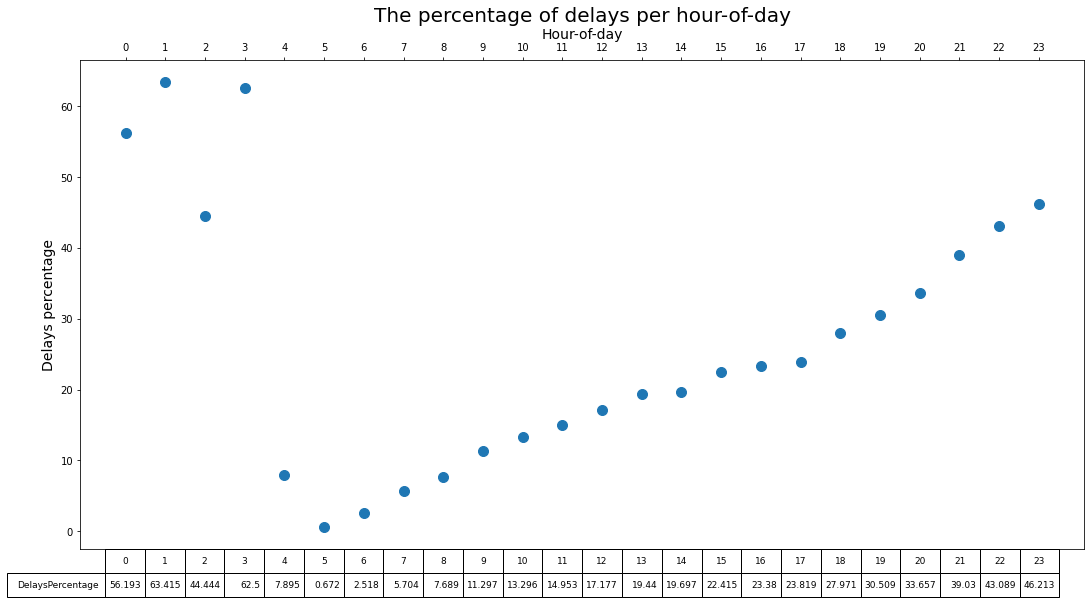

In [8]:
gb_hour['DelaysPercentage'] = gb_hour['DelaysPerHour'] / gb_hour['DepCount'] * 100

fig, ax = plt.subplots()
#ax.get_xaxis().set_visible(False) 
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

myplot = gb_hour['DelaysPercentage'].round(3).plot(table=True, legend=False, figsize=(18,9), ax=ax, linestyle='None', marker='o', markersize = 10.0)

table = myplot.tables[0]
#table.set_fontsize(12)
table.scale(0.95,2)

plt.title('The percentage of delays per hour-of-day', fontsize=20)
plt.xlabel('Hour-of-day', fontsize=14)
plt.ylabel('Delays percentage', fontsize=14)
plt.xticks(range(24))

plt.show()

Find the worse pair of origin and carrier.

In [9]:
# You may want to use 'idxmax' (like argmax, returning the row with max value of specific column)

fltr_df = data.filter(['UniqueCarrier', 'Origin', 'dep_delayed_15min'])
worse_pair = fltr_df[fltr_df['dep_delayed_15min'] == 'Y'].groupby(['Origin','UniqueCarrier']).count().idxmax()[0]

print(f'The worse pair of origin and carrier: {worse_pair}')

The worse pair of origin and carrier: ('ATL', 'DL')


# Section 2: Supervised Learning
Here, you are requested to use all features to predict the response parameter dep_delayed_15min.

* Note: some of those things are covered in notebooks 1-4.

In [10]:
# TODO: encode all categorical features as one-hot representation
# Month	DayofMonth	DayOfWeek	DepTime	UniqueCarrier	Origin	Dest	Distance	dep_delayed_15min

y = data['dep_delayed_15min'].map({'Y':1,'N':0})
X = data.drop(columns=['DepHour','dep_delayed_15min'])
# X[['Month','DayofMonth','DayOfWeek']] = X[['Month','DayofMonth','DayOfWeek']].replace(to_replace ='[cC]-', value = '', regex = True)
# X = pd.get_dummies(X, columns=['UniqueCarrier','Origin','Dest'])
X = pd.get_dummies(X, columns=['Month','DayofMonth','DayOfWeek','UniqueCarrier','Origin','Dest'])
X.head()

,DepTime,Distance,Month_c-1,Month_c-10,Month_c-11,Month_c-12,Month_c-2,Month_c-3,Month_c-4,Month_c-5,Month_c-6,Month_c-7,Month_c-8,Month_c-9,DayofMonth_c-1,DayofMonth_c-10,DayofMonth_c-11,DayofMonth_c-12,DayofMonth_c-13,DayofMonth_c-14,DayofMonth_c-15,DayofMonth_c-16,DayofMonth_c-17,DayofMonth_c-18,DayofMonth_c-19,DayofMonth_c-2,DayofMonth_c-20,DayofMonth_c-21,DayofMonth_c-22,DayofMonth_c-23,DayofMonth_c-24,DayofMonth_c-25,DayofMonth_c-26,DayofMonth_c-27,DayofMonth_c-28,DayofMonth_c-29,DayofMonth_c-3,DayofMonth_c-30,DayofMonth_c-31,DayofMonth_c-4,...,Dest_SJC,Dest_SJT,Dest_SJU,Dest_SLC,Dest_SMF,Dest_SMX,Dest_SNA,Dest_SOP,Dest_SPI,Dest_SPS,Dest_SRQ,Dest_STL,Dest_STT,Dest_STX,Dest_SUN,Dest_SWF,Dest_SYR,Dest_TEX,Dest_TLH,Dest_TOL,Dest_TPA,Dest_TRI,Dest_TTN,Dest_TUL,Dest_TUP,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TXK,Dest_TYR,Dest_TYS,Dest_VCT,Dest_VIS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YUM
0,1934,732,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1548,834,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1422,416,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1015,872,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1828,423,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# TODO: Split the data to train and test. Use test_size=0.3, and random_state=1 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [12]:
# TODO: Fit a LogisticRegression classifier to the training set
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
# TODO: print confusion matrix over the testing set
y_pred = lr_clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(np.reshape([tn, fp, fn, tp], (2,2)))

[[24149   265]
 [ 5261   325]]


In [14]:
# TODO: Calculate Precision, Recall and F score
def calc_metrics(tn, fp, fn, tp):
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f_score = (2 * precision * recall) / (precision + recall)
  print(f'The Precision: {precision}\nThe Recall: {recall}\nThe F_Score: {f_score}\n')

print('*** LogisticRegression ***')
calc_metrics(tn, fp, fn, tp)

*** LogisticRegression ***
The Precision: 0.5508474576271186
The Recall: 0.05818116720372359
The F_Score: 0.10524611398963729



In [15]:
# TODO: Similarly, print precision/recall for the following classifiers:
def get_clf(clf, clf_name, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  print(f'*** {clf_name} ***')
  calc_metrics(tn, fp, fn, tp)

# sklearn.naive_bayes.BernoulliNB
get_clf(BernoulliNB(), 'BernoulliNB')

# sklearn.neighbors.KNeighborsClassifier
get_clf(KNeighborsClassifier(), 'KNeighborsClassifier')

# sklearn.svm.LinearSVC
get_clf(LinearSVC(dual=False), 'LinearSVC')

*** BernoulliNB ***
The Precision: 0.3181818181818182
The Recall: 0.015037593984962405
The F_Score: 0.028717948717948718

*** KNeighborsClassifier ***
The Precision: 0.39699074074074076
The Recall: 0.18421052631578946
The F_Score: 0.2516507703595011

*** LinearSVC ***
The Precision: 0.5966386554621849
The Recall: 0.012710347296813463
The F_Score: 0.02489044697633655

